In [1]:
import numpy as np 
import pandas as pd 
import cv2
import random
from tqdm import tqdm
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os
import time

In [2]:
df = pd.read_csv("/Users/saurabhadvani/Downloads/full_df.csv")
df

,ID,Patient Age,Patient Sex,Left-Fundus,Right-Fundus,Left-Diagnostic Keywords,Right-Diagnostic Keywords,N,D,G,C,A,H,M,O,filepath,labels,target,filename
0,0,69,Female,0_left.jpg,0_right.jpg,cataract,normal fundus,0,0,0,1,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['N'],"[1, 0, 0, 0, 0, 0, 0, 0]",0_right.jpg
1,1,57,Male,1_left.jpg,1_right.jpg,normal fundus,normal fundus,1,0,0,0,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['N'],"[1, 0, 0, 0, 0, 0, 0, 0]",1_right.jpg
2,2,42,Male,2_left.jpg,2_right.jpg,laser spot，moderate non proliferative retinopathy,moderate non proliferative retinopathy,0,1,0,0,0,0,0,1,../input/ocular-disease-recognition-odir5k/ODI...,['D'],"[0, 1, 0, 0, 0, 0, 0, 0]",2_right.jpg
3,4,53,Male,4_left.jpg,4_right.jpg,macular epiretinal membrane,mild nonproliferative retinopathy,0,1,0,0,0,0,0,1,../input/ocular-disease-recognition-odir5k/ODI...,['D'],"[0, 1, 0, 0, 0, 0, 0, 0]",4_right.jpg
4,5,50,Female,5_left.jpg,5_right.jpg,moderate non proliferative retinopathy,moderate non proliferative retinopathy,0,1,0,0,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['D'],"[0, 1, 0, 0, 0, 0, 0, 0]",5_right.jpg
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6387,4686,63,Male,4686_left.jpg,4686_right.jpg,severe nonproliferative retinopathy,proliferative diabetic retinopathy,0,1,0,0,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['D'],"[0, 1, 0, 0, 0, 0, 0, 0]",4686_left.jpg
6388,4688,42,Male,4688_left.jpg,4688_right.jpg,moderate non proliferative retinopathy,moderate non proliferative retinopathy,0,1,0,0,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['D'],"[0, 1, 0, 0, 0, 0, 0, 0]",4688_left.jpg
6389,4689,54,Male,4689_left.jpg,4689_right.jpg,mild nonproliferative retinopathy,normal fundus,0,1,0,0,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['D'],"[0, 1, 0, 0, 0, 0, 0, 0]",4689_left.jpg
6390,4690,57,Male,4690_left.jpg,4690_right.jpg,mild nonproliferative retinopathy,mild nonproliferative retinopathy,0,1,0,0,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['D'],"[0, 1, 0, 0, 0, 0, 0, 0]",4690_left.jpg


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6392 entries, 0 to 6391
Data columns (total 19 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   ID                         6392 non-null   int64 
 1   Patient Age                6392 non-null   int64 
 2   Patient Sex                6392 non-null   object
 3   Left-Fundus                6392 non-null   object
 4   Right-Fundus               6392 non-null   object
 5   Left-Diagnostic Keywords   6392 non-null   object
 6   Right-Diagnostic Keywords  6392 non-null   object
 7   N                          6392 non-null   int64 
 8   D                          6392 non-null   int64 
 9   G                          6392 non-null   int64 
 10  C                          6392 non-null   int64 
 11  A                          6392 non-null   int64 
 12  H                          6392 non-null   int64 
 13  M                          6392 non-null   int64 
 14  O       

In [4]:
df.isnull().sum()

ID                           0
Patient Age                  0
Patient Sex                  0
Left-Fundus                  0
Right-Fundus                 0
Left-Diagnostic Keywords     0
Right-Diagnostic Keywords    0
N                            0
D                            0
G                            0
C                            0
A                            0
H                            0
M                            0
O                            0
filepath                     0
labels                       0
target                       0
filename                     0
dtype: int64

In [5]:
def has_cataract(text):
    if "cataract" in text:
        return 1
    else:
        return 0

In [6]:
df["left_cataract"] = df["Left-Diagnostic Keywords"].apply(lambda x: has_cataract(x))
df["right_cataract"] = df["Right-Diagnostic Keywords"].apply(lambda x: has_cataract(x))

In [7]:
left_cataract = df.loc[(df.C ==1) & (df.left_cataract == 1)]["Left-Fundus"].values
left_cataract[:20]

array(['0_left.jpg', '81_left.jpg', '103_left.jpg', '119_left.jpg',
       '254_left.jpg', '294_left.jpg', '330_left.jpg', '448_left.jpg',
       '465_left.jpg', '477_left.jpg', '553_left.jpg', '560_left.jpg',
       '594_left.jpg', '611_left.jpg', '625_left.jpg', '629_left.jpg',
       '691_left.jpg', '726_left.jpg', '750_left.jpg', '809_left.jpg'],
      dtype=object)

In [8]:
right_cataract = df.loc[(df.C ==1) & (df.right_cataract == 1)]["Right-Fundus"].values
right_cataract[:20]

array(['24_right.jpg', '81_right.jpg', '112_right.jpg', '188_right.jpg',
       '218_right.jpg', '345_right.jpg', '354_right.jpg', '477_right.jpg',
       '553_right.jpg', '560_right.jpg', '625_right.jpg', '726_right.jpg',
       '769_right.jpg', '949_right.jpg', '955_right.jpg', '970_right.jpg',
       '999_right.jpg', '1062_right.jpg', '1084_right.jpg',
       '1102_right.jpg'], dtype=object)

In [9]:
print("Number of images in left cataract: {}".format(len(left_cataract)))
print("Number of images in right cataract: {}".format(len(right_cataract)))

Number of images in left cataract: 304
Number of images in right cataract: 290


In [10]:
left_normal = df.loc[(df.C ==0) & (df["Left-Diagnostic Keywords"] == "normal fundus")]["Left-Fundus"].sample(1500,random_state=42).values
right_normal = df.loc[(df.C ==0) & (df["Right-Diagnostic Keywords"] == "normal fundus")]["Right-Fundus"].sample(1500,random_state=42).values
right_normal[:15]

array(['2964_right.jpg', '680_right.jpg', '500_right.jpg',
       '2368_right.jpg', '2820_right.jpg', '2769_right.jpg',
       '2696_right.jpg', '2890_right.jpg', '940_right.jpg',
       '2553_right.jpg', '3371_right.jpg', '3042_right.jpg',
       '919_right.jpg', '3427_right.jpg', '379_right.jpg'], dtype=object)

In [11]:
cataract = np.concatenate((left_cataract,right_cataract),axis=0)
normal = np.concatenate((left_normal,right_normal),axis=0)

In [12]:
print(len(cataract),len(normal))

594 3000


In [13]:
from tensorflow.keras.preprocessing.image import load_img,img_to_array
dataset_dir = "/Users/saurabhadvani/Desktop/cataract detection using deep learning/preprocessed_images"
image_size=224
labels = []
dataset = []
def create_dataset(image_category,label):
    for img in tqdm(image_category):
        image_path = os.path.join(dataset_dir,img)
        try:
            image = cv2.imread(image_path,cv2.IMREAD_COLOR)
            image = cv2.resize(image,(image_size,image_size))
        except:
            continue
        
        dataset.append([np.array(image),np.array(label)])
    random.shuffle(dataset)
    return dataset

In [14]:
dataset = create_dataset(cataract,1)

 13%|█████▌                                   | 80/594 [00:00<00:00, 794.70it/s][ WARN:0@3.407] global loadsave.cpp:248 findDecoder imread_('/Users/saurabhadvani/Desktop/cataract detection using deep learning/preprocessed_images/2231_left.jpg'): can't open/read file: check file path/integrity
[ WARN:0@3.417] global loadsave.cpp:248 findDecoder imread_('/Users/saurabhadvani/Desktop/cataract detection using deep learning/preprocessed_images/2244_left.jpg'): can't open/read file: check file path/integrity
[ WARN:0@3.420] global loadsave.cpp:248 findDecoder imread_('/Users/saurabhadvani/Desktop/cataract detection using deep learning/preprocessed_images/2251_left.jpg'): can't open/read file: check file path/integrity
 79%|███████████████████████████████▊        | 472/594 [00:00<00:00, 922.91it/s][ WARN:0@3.759] global loadsave.cpp:248 findDecoder imread_('/Users/saurabhadvani/Desktop/cataract detection using deep learning/preprocessed_images/1456_right.jpg'): can't open/read file: check fil

In [15]:
len(dataset)

588

In [16]:
dataset = create_dataset(normal,0)

100%|██████████████████████████████████████| 3000/3000 [00:03<00:00, 764.88it/s]


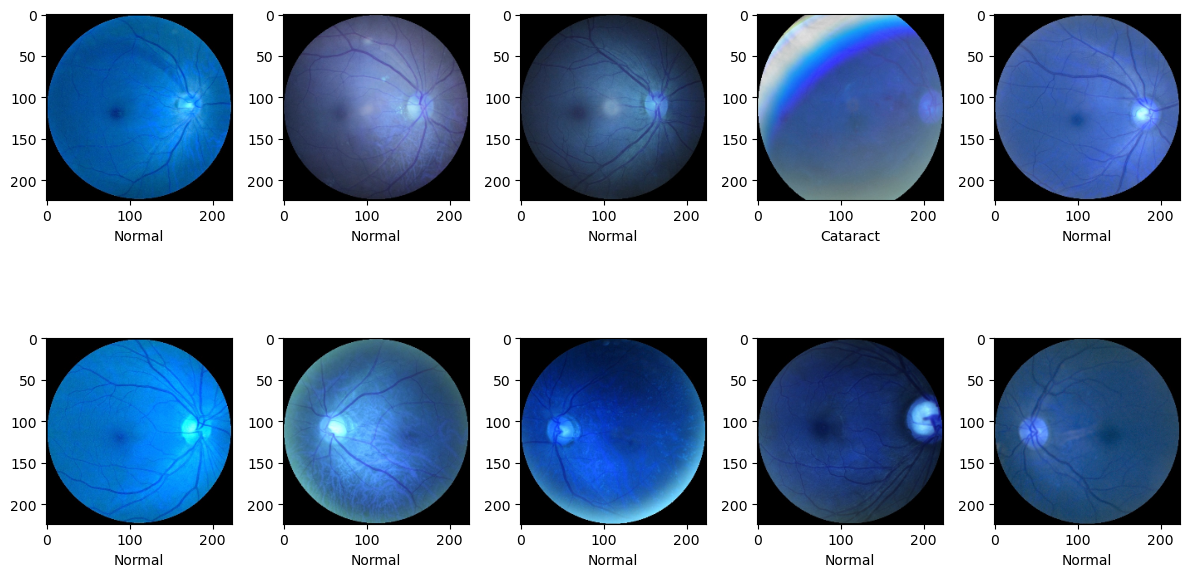

In [17]:
plt.figure(figsize=(12,7))
for i in range(10):
    sample = random.choice(range(len(dataset)))
    image = dataset[sample][0]
    category = dataset[sample][1]
    if category== 0:
        label = "Normal"
    else:
        label = "Cataract"
    plt.subplot(2,5,i+1)
    plt.imshow(image)
    plt.xlabel(label)
plt.tight_layout()    

In [18]:
x = np.array([i[0] for i in dataset]).reshape(-1,image_size,image_size,3)
y = np.array([i[1] for i in dataset])

In [19]:
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.2)

class_counts = df['C'].value_counts()
print("Total Number of Datasets Used:", len(x))

normal_train_count = (y_train == 0).sum()
cataract_train_count = (y_train == 1).sum()

normal_test_count = (y_test == 0).sum()
cataract_test_count = (y_test == 1).sum()

print("\nNumber of 'Normal' samples in training data:", normal_train_count)
print("Number of 'Cataract' samples in training data:", cataract_train_count)

print("\nNumber of 'Normal' samples in testing data:", normal_test_count)
print("Number of 'Cataract' samples in testing data:", cataract_test_count)

Total Number of Datasets Used: 3588

Number of 'Normal' samples in training data: 2398
Number of 'Cataract' samples in training data: 472

Number of 'Normal' samples in testing data: 602
Number of 'Cataract' samples in testing data: 116


In [20]:
from tensorflow.keras.applications import EfficientNetB0
efficientnet = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(image_size, image_size, 3))

In [21]:
for layer in efficientnet.layers:
    layer.trainable = False

In [22]:
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense

# Create a Sequential model
model = Sequential()

# Add EfficientNetB0 as the base
model.add(efficientnet)

# Add Flatten layer
model.add(Flatten())

# Add Dense layer with sigmoid activation (adjust units based on your task)
model.add(Dense(1, activation='sigmoid'))

# Print the model summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb0 (Functional  (None, 7, 7, 1280)        4049571   
 )                                                               
                                                                 
 flatten (Flatten)           (None, 62720)             0         
                                                                 
 dense (Dense)               (None, 1)                 62721     
                                                                 
Total params: 4112292 (15.69 MB)
Trainable params: 62721 (245.00 KB)
Non-trainable params: 4049571 (15.45 MB)
_________________________________________________________________


In [23]:
model.compile(optimizer="adam",loss="binary_crossentropy",metrics=["accuracy"])

In [24]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
checkpoint = ModelCheckpoint("effb0", monitor="val_acc", verbose=1, save_best_only=True,
                             save_weights_only=True, save_freq=3)  # Adjust the period as needed
earlystop = EarlyStopping(monitor="val_acc", patience=5, verbose=1)

In [25]:
import concurrent.futures
import time

def load_and_preprocess_data(batch):
    # Implement your data loading and preprocessing logic here
    # This function should take a batch index as input and return the preprocessed batch
    pass

start_time = time.time()

with concurrent.futures.ThreadPoolExecutor() as executor:
    # Assuming x_train and y_train are your training data
    batches = [(x_train[i:i+128], y_train[i:i+128]) for i in range(0, len(x_train), 127)]

    results = list(executor.map(load_and_preprocess_data, range(len(batches))))

end_time = time.time()
total_time = end_time - start_time

print(f"Total data loading and preprocessing time: {total_time} seconds")

# Now you can use the preprocessed data for training
history = model.fit(x_train, y_train, batch_size=128, epochs=10, validation_data=(x_test, y_test),
                    verbose=1, callbacks=[checkpoint, earlystop])


print(f"Total training time: {total_time} seconds")

Total data loading and preprocessing time: 0.0012540817260742188 seconds
Epoch 1/10
23/23 [==============================] - 43s 2s/step - loss: 0.4080 - accuracy: 0.9338 - val_loss: 0.3243 - val_accuracy: 0.9554
Epoch 2/10
23/23 [==============================] - 41s 2s/step - loss: 0.1769 - accuracy: 0.9655 - val_loss: 0.1039 - val_accuracy: 0.9652
Epoch 3/10
23/23 [==============================] - 44s 2s/step - loss: 0.0646 - accuracy: 0.9777 - val_loss: 0.0815 - val_accuracy: 0.9694
Epoch 4/10
23/23 [==============================] - 43s 2s/step - loss: 0.0464 - accuracy: 0.9857 - val_loss: 0.0691 - val_accuracy: 0.9749
Epoch 5/10
23/23 [==============================] - 45s 2s/step - loss: 0.0298 - accuracy: 0.9906 - val_loss: 0.0660 - val_accuracy: 0.9777
Epoch 6/10
23/23 [==============================] - 42s 2s/step - loss: 0.0211 - accuracy: 0.9934 - val_loss: 0.0543 - val_accuracy: 0.9805
Epoch 7/10
23/23 [==============================] - 43s 2s/step - loss: 0.0180 - accura

In [26]:
# from tensorflow.keras.models import save_model

# Assuming 'model' is your trained TensorFlow model
#model.save('myef_model.keras')

model.save('cataract_model_1.keras')

In [27]:
loss,accuracy = model.evaluate(x_test,y_test)
print("loss:",loss)
print("Accuracy:",accuracy)

23/23 [==============================] - 8s 365ms/step - loss: 0.0473 - accuracy: 0.9889
loss: 0.04730409383773804
Accuracy: 0.9888579249382019


In [28]:
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score,precision_score,recall_score,f1_score
y_pred = (model.predict(x_test) > 0.5).astype("int32")

23/23 [==============================] - 9s 361ms/step


In [29]:
print(x.shape, y.shape)

(3588, 224, 224, 3) (3588,)


In [30]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99       602
           1       0.96      0.97      0.97       116

    accuracy                           0.99       718
   macro avg       0.98      0.98      0.98       718
weighted avg       0.99      0.99      0.99       718



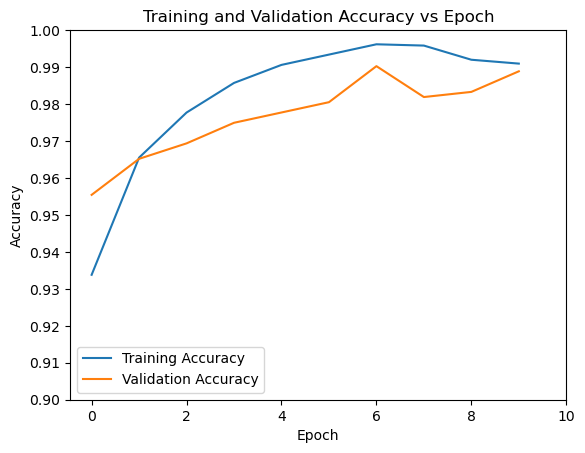

Epoch 1: Training Accuracy = 0.9338, Validation Accuracy = 0.9554
Epoch 2: Training Accuracy = 0.9655, Validation Accuracy = 0.9652
Epoch 3: Training Accuracy = 0.9777, Validation Accuracy = 0.9694
Epoch 4: Training Accuracy = 0.9857, Validation Accuracy = 0.9749
Epoch 5: Training Accuracy = 0.9906, Validation Accuracy = 0.9777
Epoch 6: Training Accuracy = 0.9934, Validation Accuracy = 0.9805
Epoch 7: Training Accuracy = 0.9962, Validation Accuracy = 0.9903
Epoch 8: Training Accuracy = 0.9958, Validation Accuracy = 0.9819
Epoch 9: Training Accuracy = 0.9920, Validation Accuracy = 0.9833
Epoch 10: Training Accuracy = 0.9909, Validation Accuracy = 0.9889


In [31]:
import matplotlib.pyplot as plt

# Assuming you have already trained your model and stored the history object
# history = model.fit(x_train, y_train, batch_size=128, epochs=10, validation_data=(x_test, y_test),
#                     verbose=1, callbacks=[checkpoint, earlystop])

# Extract training and validation accuracy
training_accuracy = history.history['accuracy']
validation_accuracy = history.history['val_accuracy']

# Plot training and validation accuracy
plt.plot(training_accuracy, label='Training Accuracy')
plt.plot(validation_accuracy, label='Validation Accuracy')
plt.title('Training and Validation Accuracy vs Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Set x-axis ticks at a more concise interval
plt.xticks(range(0, len(history.history['accuracy'])+1, 2))

# Set y-axis ticks at an interval of 0.02
plt.yticks([i/100 for i in range(90, 101, 1)])

# Show the plot
plt.show()

# Print accuracy for each epoch
for epoch, (train_acc, val_acc) in enumerate(zip(training_accuracy, validation_accuracy), 1):
    print(f"Epoch {epoch}: Training Accuracy = {train_acc:.4f}, Validation Accuracy = {val_acc:.4f}")


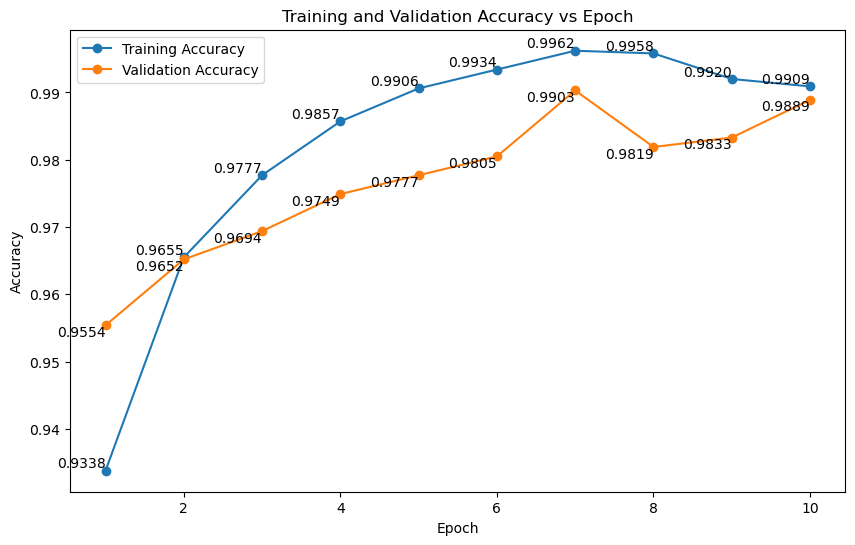

In [34]:
import matplotlib.pyplot as plt

# Provided data
epochs = list(range(1, 11))
training_accuracy = [0.9338,0.9655,0.9777,0.9857,0.9906,0.9934,0.9962,0.9958,0.9920,0.9909]
validation_accuracy = [0.9554,0.9652,0.9694,0.9749,0.9777,0.9805,0.9903,0.9819,0.9833,0.9889]

# Enlarge the figure size
plt.figure(figsize=(10, 6))

# Plot accuracy and validation accuracy
plt.plot(epochs, training_accuracy, label='Training Accuracy', marker='o')
plt.plot(epochs, validation_accuracy, label='Validation Accuracy', marker='o')
plt.title('Training and Validation Accuracy vs Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Display values on the plot (rounded to 4 decimal places)
for i, (train_acc, val_acc) in enumerate(zip(training_accuracy, validation_accuracy), 1):
    plt.text(i, train_acc, f'{train_acc:.4f}', ha='right', va='bottom')
    plt.text(i, val_acc, f'{val_acc:.4f}', ha='right', va='top')

# Show the plot
plt.show()


In [1]:
from keras.preprocessing import image
from keras.applications.efficientnet import preprocess_input
import numpy as np
from keras.models import load_model
import os

# Load the model
model = load_model("cataract_model_1.keras")

source_path = '/Users/saurabhadvani/Desktop/cataract detection using deep learning/ODIR-5K/ODIR-5K/Testing Images'

# Get a list of image files in the directory
image_files = [f for f in os.listdir(source_path) if os.path.isfile(os.path.join(source_path, f))]

for img_file in image_files:
    # Create the full path for each image
    img_path = os.path.join(source_path, img_file)

    # Load a single image and preprocess it
    img = image.load_img(img_path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_input(img_array)

    # Check prediction
    pred = model.predict(img_array)

    # Determine the predicted class based on a threshold
    threshold = 0.5  # You can adjust this threshold based on your model's characteristics
    predicted_class = 1 if pred[0][0] > threshold else 0

    # Print the result for each image
    print(f"Image: {img_file}, Predicted class: {'Normal' if predicted_class == 0 else 'Cataract'}, Confidence: {pred[0][0]}")


1/1 [==============================] - 0s 427ms/step
Image: 1128_right.jpg, Predicted class: Normal, Confidence: 3.720471113410895e-07
1/1 [==============================] - 0s 26ms/step
Image: 3544_left.jpg, Predicted class: Normal, Confidence: 1.5817171572507505e-08
1/1 [==============================] - 0s 25ms/step
Image: 3588_right.jpg, Predicted class: Normal, Confidence: 4.1228881855204236e-06
1/1 [==============================] - 0s 26ms/step
Image: 3541_right.jpg, Predicted class: Normal, Confidence: 8.8948451093529e-07
1/1 [==============================] - 0s 26ms/step
Image: 3545_left.jpg, Predicted class: Normal, Confidence: 1.9364352135675666e-11
1/1 [==============================] - 0s 27ms/step
Image: 1370_left.jpg, Predicted class: Normal, Confidence: 0.0023962599225342274
1/1 [==============================] - 0s 26ms/step
Image: 4779_left.jpg, Predicted class: Normal, Confidence: 5.5874959770108035e-08
1/1 [==============================] - 0s 26ms/step
Image: 4778

In [ ]:
import tkinter as tk
from tkinter import filedialog
from PIL import Image, ImageTk
from keras.preprocessing import image
from keras.applications.efficientnet import preprocess_input
import numpy as np
from keras.models import load_model
import os

# Load the model
model = load_model("cataract_model.keras")

# Function to preprocess the image before feeding it to the model
def preprocess_image(img_path):
    img = image.load_img(img_path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_input(img_array)
    return img_array

# Function to make predictions using the model
def make_prediction(img_path):
    img_array = preprocess_image(img_path)
    pred = model.predict(img_array)
    # Determine the predicted class based on a threshold
    threshold = 0.5  # You can adjust this threshold based on your model's characteristics
    predicted_class = 1 if pred[0][0] > threshold else 0
    return predicted_class, pred[0][0]

# Function to handle the "Load Image" button
def load_image():
    file_path = filedialog.askopenfilename(title="Select Image File")
    if file_path:
        img = Image.open(file_path)
        img.thumbnail((300, 300))  # Resize the image for display
        img = ImageTk.PhotoImage(img)
        image_label.config(image=img)
        image_label.image = img

        # Make a prediction and display the result
        predicted_class, confidence = make_prediction(file_path)
        result_label.config(text=f"Prediction: {'Normal' if predicted_class == 0 else 'Cataract'}\nConfidence: {confidence:.2f}")

# Create the main GUI window
root = tk.Tk()
root.title("Cataract Detection GUI")

# Create and place GUI elements
load_button = tk.Button(root, text="Load Image", command=load_image)
load_button.pack(pady=10)

image_label = tk.Label(root)
image_label.pack(pady=10)

result_label = tk.Label(root, text="Prediction: -")
result_label.pack(pady=10)

# Start the GUI main loop
root.mainloop()


1/1 [==============================] - 0s 27ms/step
